In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

from sklearn.manifold import TSNE
import copy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A,D=loadgraph()
        elif recon:
            E1,E2,A,D=loadgraph(recon=True, train=False,run=run,t_r=j)
            #print('recon')
        else:
            E1,E2,A,D=loadgraph(train=False)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        d_batch.append(D)
        
        
    #src1_batch=torch.stack(src1_batch)  
    #src2_batch=torch.stack(src2_batch) 
        
    #print('src_batch',src1_batch[3])
    #print('src2_batch',src2_batch[3])
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=-100)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=-100)
    
    #print('src1size',src1_batch.size())
    #print('src1',src1_batch[:,0,:],src1_batch[:,0,:].size())
    #print('src2',src2_batch[:,0,:],src2_batch[:,0,:].size())
    #print('y',y_batch)
    ##
    return src1_batch, src2_batch,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,75) #!!!!!!!!!!##100 total data size
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed_n2v.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(75,100) #!!!!!!!!
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed_n2v.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]
    #print('src_padding',src)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask



class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad

class makeLinEmb:
    def __init__(self,save=False):
        self.save=save
        
    def forward(self,s:Tensor,
                mask1:Tensor):
        
        #print('s',s[0],s.size())
        #print('mask',mask1[0],mask1.size())
        emb = []
        for i in range(s.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            emb.append(s[i,0:n])
        
        #print('emb',emb[0],emb[0].size())
        if self.save == True:
            result = torch.cat(emb, dim=0)
            print('res',result.size())
            result_np = result.detach().numpy()
            np.savetxt('./'+str(1)+'/'+'embed_n2v_lin.txt', result_np)
        return emb
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    #print(Ad[0],y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)



class Loss():
    def __init__(self,pen,tra_to_tens=False):
        self.pen=pen
        self.trans=tra_to_tens
        
    def loss (self,Ad,y):
        convert_tensor = transforms.ToTensor()
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            if self.trans:
                Ad[i]=convert_tensor(Ad[i])[0]
                
            #if i==10:
             #   print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        if self.trans:
            loss = Variable(loss, requires_grad = True)
        return loss
    


def evaluate(model,loss_fn):
    #model.eval()
    losses = 0

    src1, src2, y,d = collate_fn(31,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)




def postprocess_MinCostAss(Ad,a):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = np.append(start_nodes,0)
        start_nodes = [int(x) for x in start_nodes ]
        #print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = np.append(end_nodes,si_e[-1])
        end_nodes = [int(x) for x in end_nodes ]
        #print(end_nodes)
        
        
        tasks = np.max([right_n,left_n])
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = np.append(capacities,tasks)
        capacities = [int(x) for x in capacities]
        #print(capacities)
        
        '''
        c_A[0]=c_A[0]/c_A[0,0]
        c_A[0]=c_A[0]/(1.01*np.max(c_A[0]))
        c_A[:,0]=c_A[:,0]/c_A[0,0]
        c_A[:,0]=c_A[:,0]/(1.01*np.max(c_A[:,0]))
        '''
        
        #print(c_A)
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
        costs = np.append(costs,a*np.mean(c))                            
        costs = [int(x) for x in costs]
                                    
        #print(costs)
        
        source = 0
        sink = left_n+right_n+1
        
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-(tasks+left_n))
        
        supplies = [int(x) for x in supplies]
        #print(supplies)
        #print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
             
            
            #print('z_orig',z)
            s=np.sum(z,axis=1)
            for e in range(len(s)):
                if s[e]>1 and e!=0:
                    z[e,0]=0
            #print('z_bg_cor',z)      
            if (~z.any(axis=0)).any():
                z_col_ind=np.where(~z.any(axis=0))[0]
                z[:,z_col_ind]=c_A[:,z_col_ind]
                #print('---------z_0_col',z)
                z=postprocess_MinCostAss(np.array([z]),2*a)[0]
                #print('z_0_col_after',z)

                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

      
'''

    start_nodes = np.zeros(c_A.size(0)) + [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3
    ] + [4, 5, 6, 7]
    end_nodes = [1, 2, 3] + [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7] + [8,8,8,8]
    capacities = [2, 2, 2] + [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ] + [2, 2, 2, 2]
    costs = (
        [0, 0, 0] +
        c +
        [0, 0, 0 ,0])

    source = 0
    sink = 8
    tasks = 4
    supplies = [tasks, 0, 0, 0, 0, 0, 0, 0, -tasks]

    # Add each arc.
    for i in range(len(start_nodes)):
        smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        smcf.set_node_supply(i, supplies[i])

    # Find the minimum cost flow between node 0 and node 10.
    status = smcf.solve()

    if status == smcf.OPTIMAL:
        print('Total cost = ', smcf.optimal_cost())
        print()
        for arc in range(smcf.num_arcs()):
            # Can ignore arcs leading out of source or into sink.
            if smcf.tail(arc) != source and smcf.head(arc) != sink:

                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if smcf.flow(arc) > 0:
                    print('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                          (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')
            pp_A.append(f_add)

        
    return pp_A

'''

def make_reconstructed_edgelist(A,run):
    
    e_start=[2,3,4]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        #print('M0',M)
        X=M[0][1:]
        M=M[1:,1:]
        #print('M1',M)
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                if M[z,j]!=0:
                    #print(z,e_start)
                    e1.append(int(e_start[z]))
                    #print('e',e_mid)
                    e2.append(int(e_mid[j]))
                if z==0 and X[j]!=0:
                    e1.append(int(1))
                    e2.append(int(e_mid[j]))
                    
        
        e_start=e_mid
        #print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d,a):
    
    Ad_n = []
    #Ad_n=copy.deepcopy(Ad)
    
    for h in range(len(Ad)):
        
        A_t,ill_flag=treshold(Ad[h],t=0.5)
        
        #print('ill_flag',ill_flag)
        #print(Ad[h],A_t)
        if ill_flag==True:
            Ad[h]=np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy())
            A_t = postprocess_MinCostAss(np.array([Ad[h]]),a)[0]
            
        #print(Ad[h],A_t)
        Ad_n.append(A_t)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad_n

def treshold(matrix, t):
    z=np.where(matrix >= t, 1, 0)
    
    ill_flag=False

      
    if (~z.any(axis=0)).any() or any(np.sum(z[:,1:], axis=0)>1):
        ill_flag=True
          
    return z,ill_flag

def err_perc(a,b):
    w=0
    s=0
    for i in range(len(a)):
        m=a[i]-b[i].detach().numpy()
        w=w+np.sum(np.abs(m))
        s=s+np.size(m)
    
    
    print('w,s',w,s)
    
    return w*100/s



'''mport numpy as np

# Define a matrix with duplicates of the first row
matrix = np.array([[1, 2, 3], [1, 2, 3], [4, 5, 6], [1, 2, 3], [7, 8, 9]])

# Find all duplicates of the first row, except the first row
duplicates = [row for row in matrix if np.array_equal(row, matrix[0]) and row is not matrix[0]]

# Keep all rows that are not duplicates of the first row
new_matrix = [row for row in matrix if row not in duplicates]

# Convert the list of rows back to a matrix
new_matrix = np.array(new_matrix)

print(new_matrix)'''

In [3]:
class LinearLayer(nn.Module):
    def __init__(self,
                 input_dim: int,
                 dim_out: int = 400,
                 out = False, 
                 dropout: float = 0.1):
        super(LinearLayer, self).__init__()
        
        
        

        
        self.out=out 
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        self.Linemb=makeLinEmb()
        
        self.lina = nn.Sequential(
            nn.Linear(input_dim, int(dim_out/2)),
            nn.LeakyReLU())
        
        self.lina_2 = nn.Sequential(
            nn.Linear(int(dim_out/2), dim_out),
            nn.LeakyReLU())
        
        self.lina_3 = nn.Sequential(
            nn.Linear(dim_out, dim_out),
            nn.LeakyReLU())
        
        
        
        #self.linb = nn.Sequential(
        #    nn.Linear(input_dim, int(dim_out/2)),
        #    nn.LeakyReLU())
        
        #self.linb_2 = nn.Sequential(
        #    nn.Linear(int(dim_out/2), dim_out),
        #    nn.LeakyReLU())
        
        #self.linb_3 = nn.Sequential(
        #    nn.Linear(dim_out, dim_out),
        #    nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor,
                run=0):
        
        #print('sizes1',src_t1.size())
        
        src_t1 =torch.transpose(src_t1,0,1)
        src_t2 =torch.transpose(src_t2,0,1) 
        
        #print('sizes1a',src_t1.size())
        #print('sizes2a',src_t2.size())
        
        src_t1 = self.lina(src_t1)
        src_t2 = self.lina(src_t2)
        
        src_t1 = self.lina_2(src_t1)
        src_t2 = self.lina_2(src_t2)
        
        src_t1 = self.lina_3(src_t1)
        src_t2 = self.lina_3(src_t2)
        
        src_t2 = torch.transpose(src_t2,1,2)
        
        #print('sizes1',src_t1.size())
        #print('sizes2',src_t2.size())

        
        z=self.sig(torch.bmm(src_t1,src_t2))
        
        #print('sizesz',z.size())
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)
        
        emb=self.Linemb.forward(src_t1,src_padding_mask1)

       
        
        if self.out:
            return Ad,out1,out2,out_dec1,src_t1,src_t2
        else:
            return Ad

In [4]:
input_dim=50

dim_out= 400



lin = LinearLayer(input_dim,dim_out)


lin = lin.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(lin.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [5]:
from timeit import default_timer as timer
NUM_EPOCHS = 200

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(lin, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(lin,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')


Epoch: 1, Train loss: 4.794, Val loss: 4.890, Epoch time = 2.936s
Epoch: 2, Train loss: 3.443, Val loss: 4.379, Epoch time = 3.155s
Epoch: 3, Train loss: 3.386, Val loss: 4.000, Epoch time = 3.021s
Epoch: 4, Train loss: 3.236, Val loss: 4.666, Epoch time = 2.892s
Epoch: 5, Train loss: 3.752, Val loss: 4.687, Epoch time = 2.870s
Epoch: 6, Train loss: 4.165, Val loss: 3.760, Epoch time = 2.827s
Epoch: 7, Train loss: 3.677, Val loss: 3.828, Epoch time = 2.757s
Epoch: 8, Train loss: 4.642, Val loss: 3.897, Epoch time = 2.804s
Epoch: 9, Train loss: 4.195, Val loss: 4.100, Epoch time = 2.726s
Epoch: 10, Train loss: 5.355, Val loss: 3.841, Epoch time = 2.741s
Epoch: 11, Train loss: 4.003, Val loss: 5.184, Epoch time = 2.940s
Epoch: 12, Train loss: 3.918, Val loss: 3.837, Epoch time = 3.071s
Epoch: 13, Train loss: 3.617, Val loss: 4.254, Epoch time = 3.135s
Epoch: 14, Train loss: 4.276, Val loss: 3.953, Epoch time = 2.776s
Epoch: 15, Train loss: 4.334, Val loss: 4.093, Epoch time = 2.749s
Epoc

Epoch: 124, Train loss: 3.321, Val loss: 3.561, Epoch time = 2.557s
Epoch: 125, Train loss: 3.866, Val loss: 3.488, Epoch time = 2.437s
Epoch: 126, Train loss: 4.092, Val loss: 4.263, Epoch time = 2.413s
Epoch: 127, Train loss: 3.981, Val loss: 3.866, Epoch time = 2.366s
Epoch: 128, Train loss: 3.964, Val loss: 3.667, Epoch time = 2.421s
Epoch: 129, Train loss: 4.161, Val loss: 4.370, Epoch time = 2.556s
Epoch: 130, Train loss: 4.077, Val loss: 3.672, Epoch time = 2.443s
Epoch: 131, Train loss: 3.927, Val loss: 4.055, Epoch time = 2.587s
Epoch: 132, Train loss: 4.072, Val loss: 4.123, Epoch time = 2.519s
Epoch: 133, Train loss: 4.320, Val loss: 3.778, Epoch time = 2.516s
Epoch: 134, Train loss: 4.955, Val loss: 3.715, Epoch time = 2.807s
Epoch: 135, Train loss: 3.247, Val loss: 4.168, Epoch time = 2.683s
Epoch: 136, Train loss: 3.547, Val loss: 4.353, Epoch time = 2.491s
Epoch: 137, Train loss: 3.961, Val loss: 4.160, Epoch time = 2.564s
Epoch: 138, Train loss: 3.647, Val loss: 4.352, 

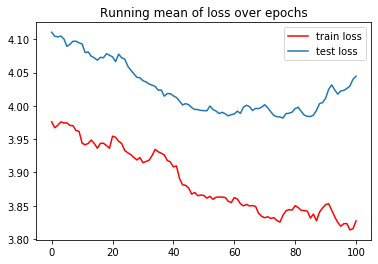

In [8]:
loss_over_time= np.loadtxt('./train_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=100
plt.plot(np.convolve(loss_over_time, np.ones(N)/N, mode='valid'),c='red',label='train loss')
plt.plot(np.convolve(test_error, np.ones(N)/N, mode='valid'),label='test loss')
plt.title('Running mean of loss over epochs')
plt.legend()

In [7]:
a=np.linspace(0.01,1,num=1)
#a=[0.1]

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()
convert_tensor = transforms.ToTensor()
lo=[]
for k in range(len(a)):
    print(lo)
    print('k---',k)
    g=[]
    for v in range(10):
        #print('v-',v)


        src1, src2, y,d = collate_fn(1,-100,train=False)

        src1= src1.to(DEVICE)
        src2= src2.to(DEVICE)



        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)

        Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
        #print(Ad[0])

        Ad_real = complete_postprocess(Ad,d,a[k])
        #print(Ad_real[0])
        #print(y[0])
        
        Ad_real= convert_tensor(Ad_real[0])


        l = nn.CrossEntropyLoss()
        s = l(Ad_real[0], y[0])
        g.append(s)
    lo.append(np.mean(g))

plt.plot(a,lo)






NameError: name 'transformer' is not defined

#postprocess Training


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


NUM_EPOCHS=1000


transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0,tra_to_tens=True)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00001, betas=(0.9, 0.98), eps=1e-9)

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch_post_process(transformer, optimizer,loss_fn)
    end_time = timer()
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_pp.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')

In [ ]:
#recon+testerror
for r in range(1,3):
    src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=r)

    #print(src1.size())
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    
    transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
    transformer.eval()
    
    

    Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
    
    val_loss = evaluate(transformer,loss_fn)
    #print('L',val_loss)
    a=0.1
    pp_A = complete_postprocess(Ad,d,a)
    
    err_p=err_perc(pp_A,y)
    print('err',r,err_p)

#print(src1.size())

    #print('y',y[6])
    #print('Ad',Ad[6])
    #print('pp',pp_A[6])
    #print('d',d[6])

#for i in range(5):
#    print(pp_A[i])
    
    
    make_reconstructed_edgelist(pp_A,run=r)

In [ ]:
print(stop)

In [ ]:
#Umap AdjacencyTrans2


emb_size= 150 ###!!!!24 for n2v emb
nhead= 6    ###!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer_2(num_encoder_layers, emb_size, nhead,out=True)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))


NUM_EPOCHS = 2

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_Ad2.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_Ad2.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    

    
    
    
loss_over_time= np.loadtxt('./train_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=1

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))    



In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap.umap_ as umap


transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()

run=95
t= 8
src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=run)
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)


Ad,out1,out2,out_dec1,src_t1,src_t2 = transformer(src1,src2,src_padding_mask1,src_padding_mask2)



out_dec1=torch.transpose(out_dec1,2,1)
out_dec1=torch.transpose(out_dec1,1,0)
print(out_dec1.shape)


src_t1=src_t1[:,t,:]#[1:]
src_t2=src_t2[:,t,:]#[1:]

ind1=np.where(src_t1 == -100)
ind2=np.where(src_t2 == -100)

a=out1.detach().numpy()
b=out_dec1.detach().numpy()

a=a[:,t,:]#[1:]
b=b[:,t,:]#[1:]

a=a[0:ind1[0][0]]

b=b[0:ind2[0][0]]




blue_list=['#2a186c','#2e1f98','#1a3b9f','#0c5294','#16638d','#25738a','#328388','#3c9387','#45a383','#53b47c','#69c46f']
red_list=['#2f0303','#6e0302','#9a0303','#c40303','#f30203','#ff1f03','#ff4a04','#fe7104','#ffa001','#fec701','#fef903']
c_list=[]

for p in range(len(a)):
    c_list.append(blue_list[p])
    
for t in range(len(b)):
    c_list.append(red_list[t])

#print(c_list)
c_list=['blue']*len(a)+['black']*len(b)

#print(src_t1.shape)

src=np.vstack((a,b))

'''
mnist = fetch_openml("mnist_784", version=1)
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, stratify=mnist.target, random_state=42
)
'''
print(src.shape)
reducer = umap.UMAP(metric='cosine',n_neighbors=4)
embedding = reducer.fit_transform(src)
#print(embedding_train,embedding_train.shape)
#embedding_test = reducer.transform(X_test)
print(embedding)
plt.scatter(embedding[:, 0],embedding[:, 1],c=c_list)
plt.gca().set_aspect('equal')
'''[[11.102701   9.834718 ]
 [10.975245  11.376655 ]
 [11.55883   10.9941   ]
 [10.942158  10.440168 ]
 [10.304249  10.682447 ]
 [10.096922  10.017049 ]
 [10.49952   12.192604 ]
 [ 8.663966  11.4105625]
 [ 9.177266  12.255981 ]
 [ 8.936496  10.613881 ]
 [10.011719  11.911004 ]
 [ 9.29462   11.477478 ]
 [ 9.607173  10.698044 ]]'''

#plt.savefig('./umap_1_12_16.png',transparent=False)
#plt.savefig('./umap_1_12_16.png',transparent=False)

In [ ]:
tsne = TSNE(n_components=2)
print(src.shape)
tsne_results = tsne.fit_transform(src)



print(tsne_results)

plt.scatter(tsne_results[:,0],tsne_results[:,1],c=c_list)
plt.gca().set_aspect('equal')
#plt.savefig('./tsne_1_12_16.png',transparent=False)